In [42]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib.dates import DateFormatter

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
from sqlalchemy import create_engine
from sqlalchemy import Column, Integer, String, Float

from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()

from sqlalchemy import create_engine, inspect

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [7]:
# Reflect an existing database into a new model

Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# View all classes  automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#First figure out last point in date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [12]:
# Calculate the date 1 year ago from the last data point in the database
#Use DateTime to get date one year ago 
one_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(one_year)

2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores

#BUT THIS ALL ALL NOT ONE YEAR - SYNTAX 
data = pd.read_sql("SELECT date, prcp FROM Measurement", conn)
#Session.query(Measurement).filter(Measurement.date <= '2017-08-23').\
        #filter(Measurement.date >= '2016-08-23')
#print(data)
data.head()

,date,prcp
0,2010-01-01,0.08
1,2010-01-02,0.00
2,2010-01-03,0.00
3,2010-01-04,0.00
4,2010-01-06,NaN


In [14]:
#precipitation scores for past year 
# Filer out one year of data 
precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > one_year).\
    order_by(Measurement.date).all()

#Make DF
precip_df = pd.DataFrame(precip)
precip_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column

precip_sort = precip_df.set_index('date')
precip_sort.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


In [16]:
# Sort the dataframe by date
precip_sort = precip_sort.sort_values(by="date").dropna()
precip_sort

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15
...,...
2017-08-22,0.50
2017-08-23,0.08
2017-08-23,0.00


In [17]:
#normalize data

#precip_sort = pd.DataFrame({"Date": [], "prcp": []})

#column_maxes = precip_sort.max()
#precip_sort_max = column_maxes.max()
#precip_sort_normalized_df = df / df_max

#print(precip_sort_normalized_df)

NameError: name 'ax' is not defined

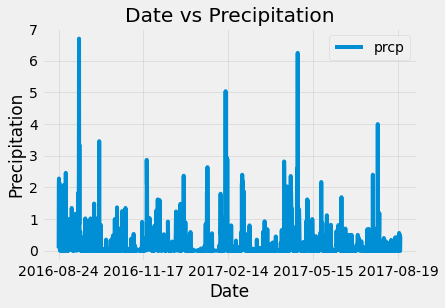

In [43]:
# Use Pandas Plotting with Matplotlib to plot the data
# Create Date vs. Prcp Plot scatter plot

precip_sort.plot();
# Set title/
plt.title("Date vs Precipitation")

# Set x axis label
#FIX DATES
plt.xlabel("Date")

# Set y axis label
plt.ylabel("Precipitation")

# Set grid line
plt.grid(linestyle='-', linewidth=1, alpha = 0.5)

date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)



In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_sort.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?

Avaliable_stations = session.query(Station).count()
Avaliable_stations

9

In [21]:
#Create inspector 
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [22]:
#names of table w/i db
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [23]:
# List column names and types -meaurment
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [24]:
# List column names and types -station
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?

Active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
Active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
# Define most active station 
Most_Active = Active_stations[0][0]
print (Most_Active)

USC00519281


In [40]:
#WHY WONT any of these print?
#calculate the lowest temperature recorded, Join 
Most_Active_Cold = session.query(func.min(Measurement.tobs))\
    .filter(Measurement.station == Most_Active).all()
print({f"Coldest Temp: {Most_Active_Cold} "})

# highest temperature recorded, and 
Most_Active_Hot = session.query(func.max(Measurement.tobs))\
    .filter(Measurement.station == Most_Active).all()
print({f"Hottest Temp: ({Most_Active_Hot}) "})
#Average temperature of the most active station?

Avg_station = session.query(func.avg(Measurement.tobs))\
.filter(Measurement.station == Most_Active).all()
print({f"Average Temp:{Avg_station}"})

{'Coldest Temp: [(54.0,)] '}
{'Hottest Temp: ([(85.0,)]) '}
{'Average Temp:[(71.66378066378067,)]'}


In [28]:
 # Choose the station with the highest number of temperature observations.
Most_tobs = session.query(func.max(Measurement.tobs)).all()
print({f"Station {Most_Active} is the most active with {Most_tobs} observations"})
Most_tobs


{'Station USC00519281 is the most active with [(87.0,)] observations'}


[(87.0)]

In [29]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


#Twelve_months = Session.query(measurement.station, measurement.tobs)
Twelve_months = session.query(Measurement.station, Measurement.tobs).\
        filter(Measurement.station == Most_Active).\
        filter(Measurement.date >= one_year).all()
Twelve_months_df = pd.DataFrame(Twelve_months,columns =[
                "Date", 
                "Temperature" ])
Twelve_months_df.set_index('Date', inplace=True)
Twelve_months_df



,Temperature
Date,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0
...,...
USC00519281,77.0
USC00519281,77.0
USC00519281,76.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000269DA1FB860>]],
      dtype=object)

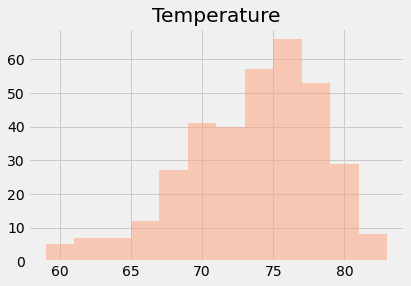

In [30]:
Twelve_months_df.hist(column = "Temperature",color='lightsalmon', alpha=0.5,  bins = 12)


## Bonus Challenge Assignment

In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [45]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#Trip Dates - 2/14/17 - 2/3/17
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-02-14', '2017-03-05'))
calc_temps_df = pd.DataFrame({
                "Min":TMIN,
                "Avg":TAVG,
                "Max":TMAX
    
                })
calc_temps_df

[(61.0, 71.13223140495867, 79.0)]


NameError: name 'TMIN' is not defined

In [ ]:
# Plot the results from your previous query as a bar chart.

# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Create Date vs. Prcp Plot scatter plot
calc_temps.plt.bar(Measurement['date'], precip_sort["TAVG"], facecolor = "lightblue", edgecolor = "black")

# Set title/
plt.title("Date vs Precipitation")

# Set x axis label
#FIX DATES
plt.xlabel("Date")

# Set y axis label
plt.ylabel("Precipitation")

# Set grid line
plt.grid(linestyle='-', linewidth=1, alpha = 0.5)



In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
